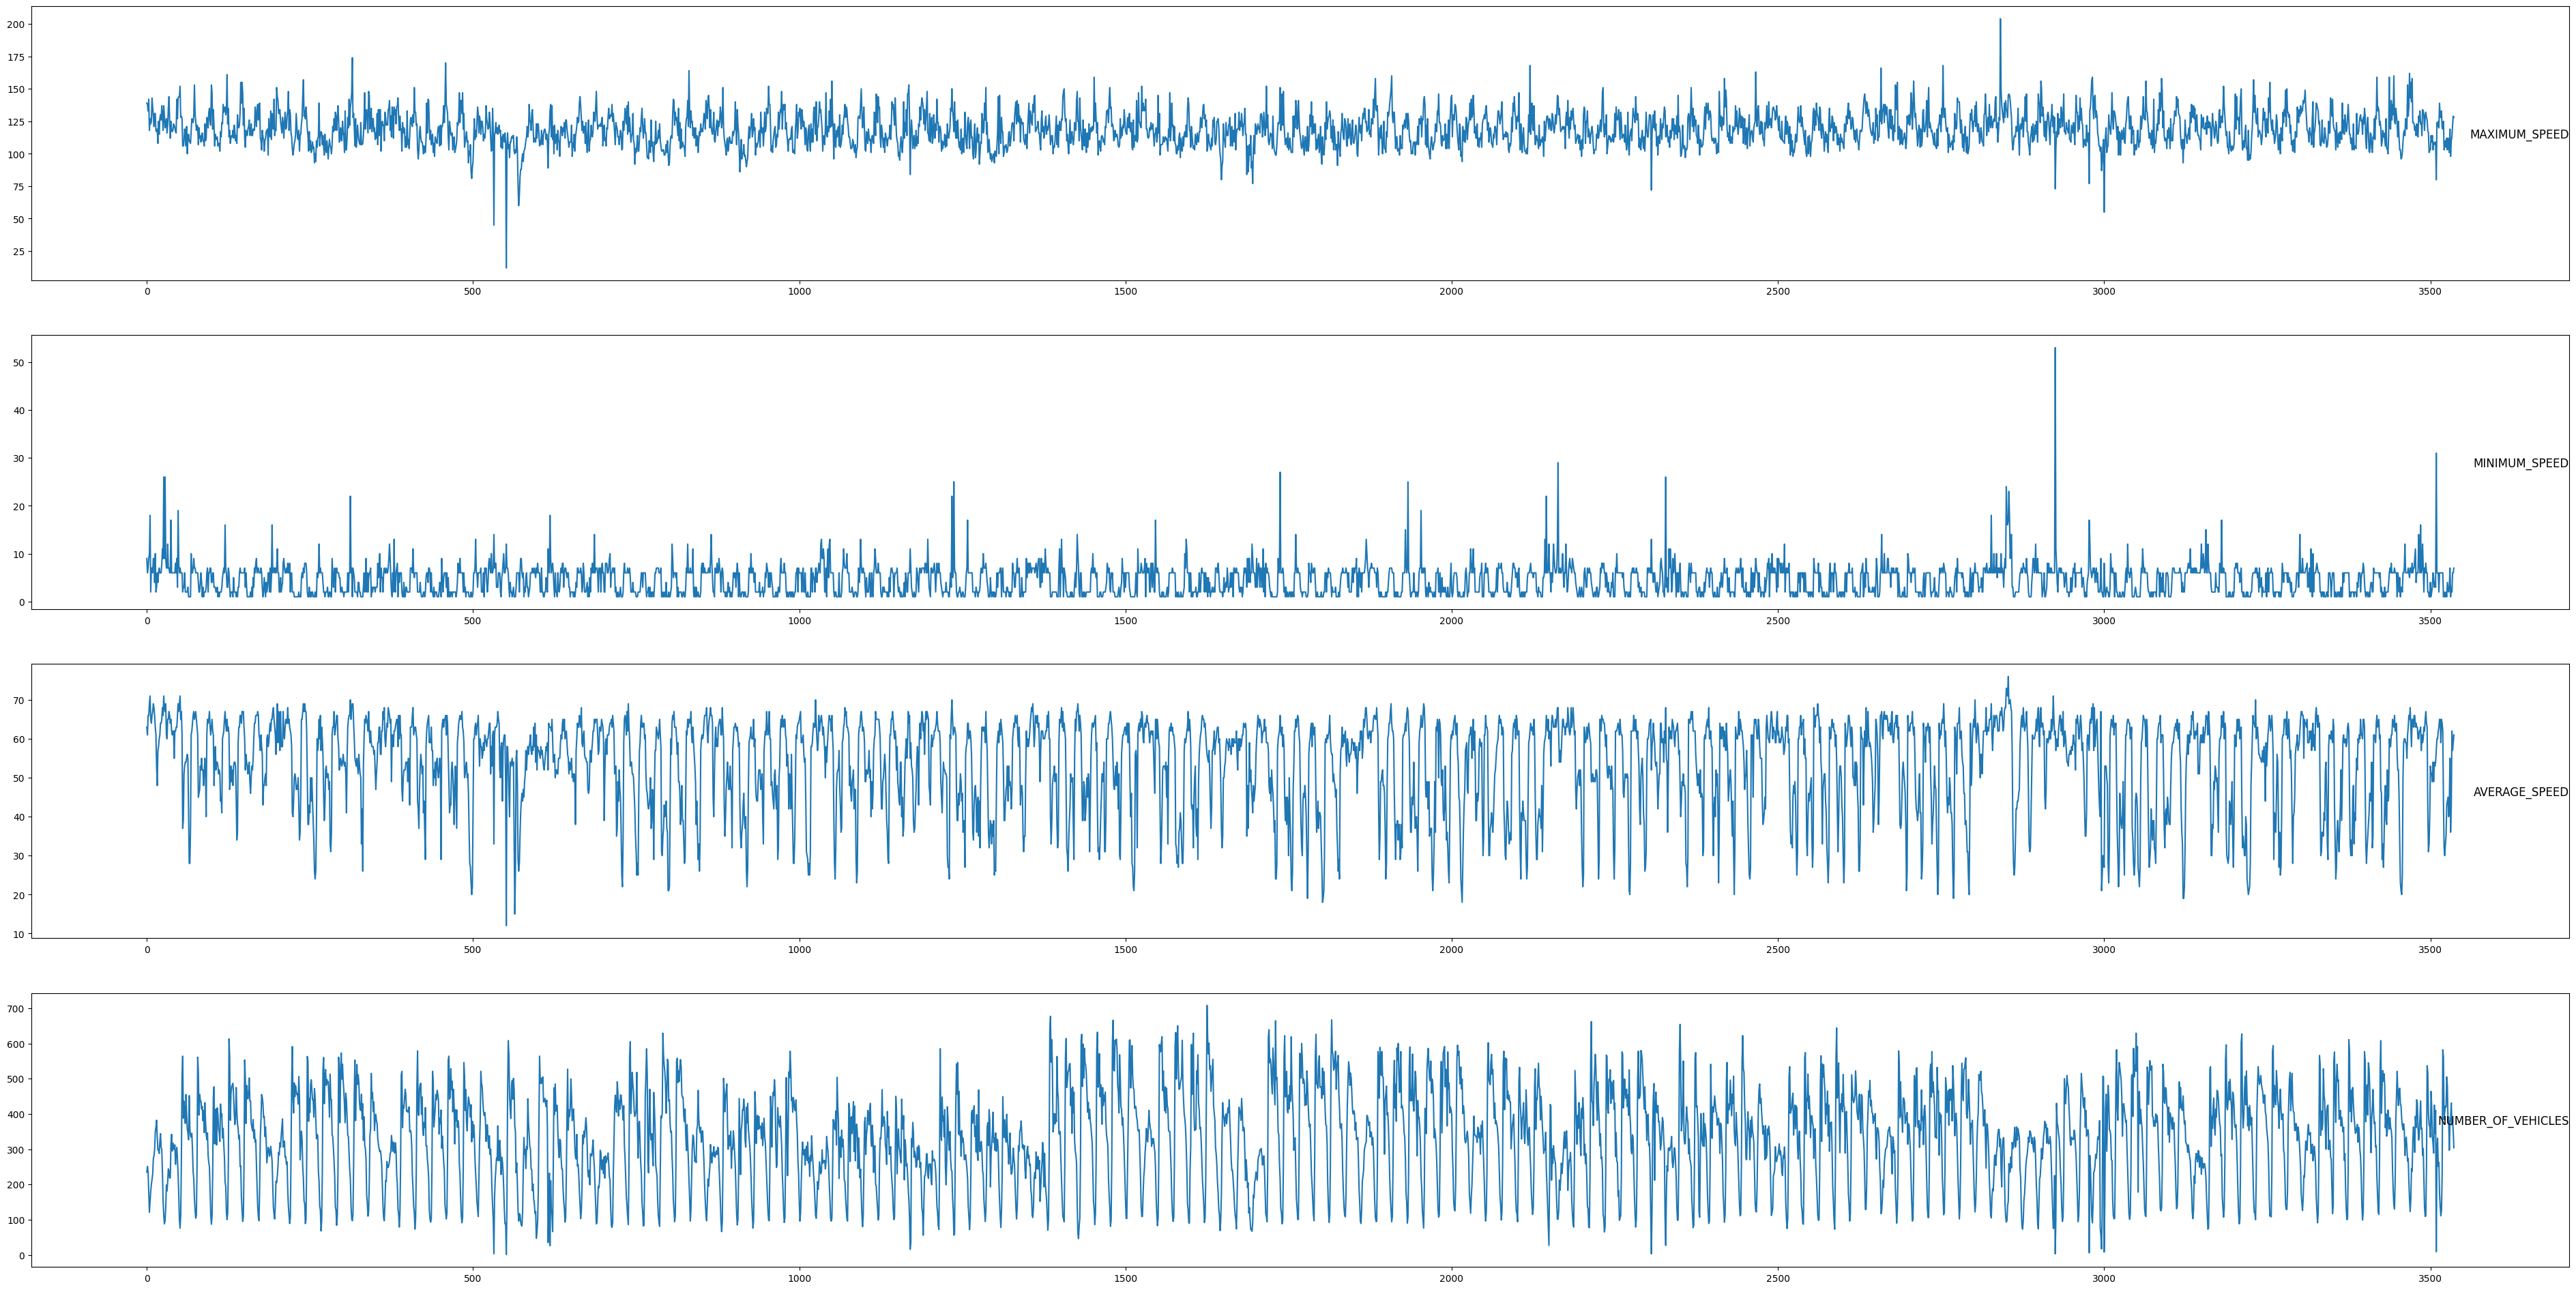

In [1]:
from pandas import read_excel
from datetime import datetime
import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot

# load dataset
dataset = read_excel(r'C:\sxk96j_6ay.xlsx', header=0, index_col=0)
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure(figsize=(48, 24))
for group in groups:
 pyplot.subplot(len(groups), 1, i)
 pyplot.plot(values[:, group])
 pyplot.title(dataset.columns[group], y=0.5, loc='right')
 i += 1
pyplot.show()

In [2]:
# prepare data for lstm
import numpy as np
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
                cols.append(df.shift(i))
                names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
                cols.append(df.shift(-i))
                if i == 0:
                        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
                else:
                        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
                agg.dropna(inplace=True)
        return agg

In [4]:
# specify the number of lag and Step hours
n_hours = 6
n_steps = 3
n_features = 4
n_obs = n_hours * n_features
n_x = (n_hours * n_features) - n_steps
# frame as supervised learning
reframed = series_to_supervised(values, n_hours, n_steps)
# drop columns we don't want to predict

for i in range (0,n_steps):
   reframed.drop(reframed.columns[[n_obs+i,n_obs+i+1,n_obs+i+3]], axis=1, inplace=True) 

reframed

var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var1(t-5)  var2(t-5)  \
6         139.0        9.0       63.0      235.0      138.0        6.0   
7         138.0        6.0       61.0      251.0      133.0        7.0   
8         133.0        7.0       66.0      234.0      142.0        9.0   
9         142.0        9.0       66.0      180.0      118.0       10.0   
10        118.0       10.0       69.0      121.0      127.0       18.0   
...         ...        ...        ...        ...        ...        ...   
3530      105.0        2.0       35.0      420.0      112.0        1.0   
3531      112.0        1.0       43.0      505.0      103.0        4.0   
3532      103.0        4.0       44.0      480.0      112.0        3.0   
3533      112.0        3.0       45.0      378.0      108.0        2.0   
3534      108.0        2.0       40.0      391.0      101.0        3.0   

      var3(t-5)  var4(t-5)  var1(t-4)  var2(t-4)  ...  var2(t-2)  var3(t-2)  \
6          61.0      251.0      133.0        7.0  ...       10.0       69.0   
7          66.0      234.0      142.0        9.0  ...       18.0       71.0   
8          66.0      180.0      118.0       10.0  ...        2.0       65.0   
9          69.0      121.0      127.0       18.0  ...        7.0       64.0   
10         71.0      152.0      123.0        2.0  ...        7.0       66.0   
...         ...        ...        ...        ...  ...        ...        ...   
3530       43.0      505.0      103.0        4.0  ...        2.0       40.0   
3531       44.0      480.0      112.0        3.0  ...        3.0       44.0   
3532       45.0      378.0      108.0        2.0  ...        7.0       55.0   
3533       40.0      391.0      101.0        3.0  ...        1.0       36.0   
3534       44.0      297.0      119.0        7.0  ...        3.0       43.0   

      var4(t-2)  var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var3(t)  \
6         121.0      127.0       18.0       71.0      152.0     65.0   
7         152.0      123.0        2.0       65.0      180.0     64.0   
8         180.0      125.0        7.0       64.0      200.0     66.0   
9         200.0      143.0        7.0       66.0      214.0     67.0   
10        214.0      136.0        6.0       67.0      228.0     69.0   
...         ...        ...        ...        ...        ...      ...   
3530      391.0      101.0        3.0       44.0      297.0     55.0   
3531      297.0      119.0        7.0       55.0      373.0     36.0   
3532      373.0       98.0        1.0       36.0      387.0     43.0   
3533      387.0      110.0        3.0       43.0      431.0     62.0   
3534      431.0      113.0        2.0       62.0      369.0     57.0   

      var3(t+1)  var3(t+2)  
6          64.0       66.0  
7          66.0       67.0  
8          67.0       69.0  
9          69.0       68.0  
10         68.0       66.0  
...         ...        ...  
3530       36.0       43.0  
3531       43.0       62.0  
3532       62.0       57.0  
3533       57.0       59.0  
3534       59.0       61.0  

[3529 rows x 27 columns]

In [5]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)

In [6]:
# split into train and test sets
# %60 Train % 40 Test
TRAIN_SIZE = 0.60
train = reframed[:int(len(reframed)*TRAIN_SIZE), :]
test = reframed[int(len(reframed)*TRAIN_SIZE):, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_steps:]
test_X, test_y = test[:, :n_obs], test[:, -n_steps:]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, len(test_X))

(2117, 24) (2117, 3) (1412, 24) (1412, 3) 1412


In [7]:
from keras.models import Sequential
from keras.layers import Dense , Dropout
from keras.layers import LSTM

from math import sqrt
from sklearn.metrics import mean_squared_error
from numpy import concatenate
from matplotlib import pyplot

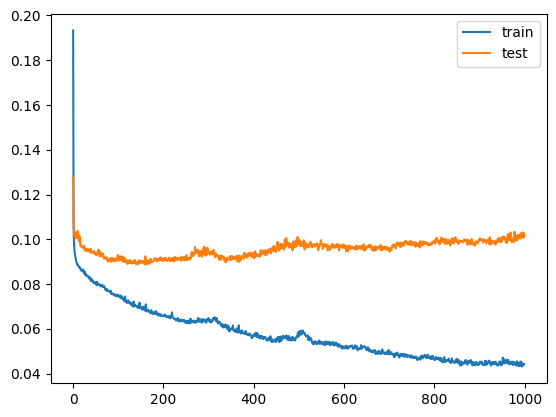

In [8]:
# design network
model = Sequential()
model.add(Dense(100, activation='relu', input_dim = (n_obs)))
#model.add(Dropout(0.15))
#model.add(Dense(100, activation='relu' ))
#model.add(Dropout(0.15))
model.add(Dense(80, activation='relu' ))
model.add(Dense(n_steps))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=1000, batch_size=32, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [9]:
# make a prediction
pred_train_y = model.predict(train_X)
#train_X = train_X.reshape((train_X.shape[0], n_obs))

67/67 [==============================] - 0s 2ms/step


In [10]:
# invert scaling for forecast
pred_train_y = concatenate((train_X[:, -n_obs:], pred_train_y), axis=1)
pred_train_y = scaler.inverse_transform(pred_train_y)
pred_train_y = pred_train_y[:,-n_steps:]

In [11]:
# invert scaling for actual
#train_y = train_y.reshape((len(train_y), n_steps))
train_y = concatenate((train_X[:, -n_obs:], train_y), axis=1)
train_y = scaler.inverse_transform(train_y)
train_y = train_y[:,-n_steps:]

In [12]:
# make a prediction
pred_test_y = model.predict(test_X)
#test_X = test_X.reshape((test_X.shape[0], n_obs))

# invert scaling for forecast
pred_test_y = concatenate(( test_X[:, -n_obs:], pred_test_y), axis=1)
pred_test_y = scaler.inverse_transform(pred_test_y)
pred_test_y = pred_test_y[:,-n_steps:]
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), n_steps))
test_y = concatenate((test_X[:, -n_obs:], test_y), axis=1)
test_y = scaler.inverse_transform(test_y)
test_y = test_y[:,-n_steps:]

45/45 [==============================] - 0s 3ms/step


In [13]:
# calculate RMSE
rmse_train = sqrt(mean_squared_error(train_y, pred_train_y))
print("Train data score: %.2f RMSE" % rmse_train)

rmse_test = sqrt(mean_squared_error(test_y, pred_test_y))
print("Test data score: %.2f RMSE" % rmse_test)

Train data score: 4.96 RMSE
Test data score: 9.41 RMSE


In [14]:
from sklearn.metrics import mean_absolute_percentage_error

error_mape_tr = 100*mean_absolute_percentage_error(train_y, pred_train_y)
print("Train data score: %.2f MAPE" % error_mape_tr)

error_mape_t = 100*mean_absolute_percentage_error(test_y, pred_test_y)
print("Test data score: %.2f MAPE" % error_mape_t)
error_mape_t0 = 100*mean_absolute_percentage_error(test_y[:,0], pred_test_y[:,0])
print("Test t zamanı score: %.2f MAPE" % error_mape_t0)
error_mape_t1 = 100*mean_absolute_percentage_error(test_y[:,1], pred_test_y[:,1])
print("Test t+1 zamanı score: %.2f MAPE" % error_mape_t1)
error_mape_t2 = 100*mean_absolute_percentage_error(test_y[:,2], pred_test_y[:,2])
print("Test t+2 zamanı score: %.2f MAPE" % error_mape_t2)

Train data score: 7.50 MAPE
Test data score: 15.59 MAPE
Test t zamanı score: 12.25 MAPE
Test t+1 zamanı score: 16.40 MAPE
Test t+2 zamanı score: 18.12 MAPE


In [15]:
mdape_tr = np.median((np.abs(np.subtract(train_y, pred_train_y)/ train_y))) * 100
print("Train data score: %.2f MdAPE" % mdape_tr)

mdape_t = np.median((np.abs(np.subtract(test_y, pred_test_y)/ test_y))) * 100
print("Test data score: %.2f MdAPE" % mdape_t)

Train data score: 3.88 MdAPE
Test data score: 7.45 MdAPE


In [16]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

error_smape_tr = smape(train_y, pred_train_y)
print("Train data score: %.2f SMAPE" % error_smape_tr)

error_smape_t = smape(test_y, pred_test_y)
print("Test data score: %.2f SMAPE" % np.mean(error_smape_t))

Train data score: 21.18 SMAPE
Test data score: 41.43 SMAPE


In [17]:
from sklearn.metrics import mean_absolute_error
e_tr = train_y - pred_train_y
scale = mean_absolute_error(train_y[1:], train_y[:-1])
mase_tr = np.mean(np.abs(e_tr / scale))
print("Train data score: %.2f MASE" % mase_tr)

e_t = test_y - pred_test_y
scale = mean_absolute_error(test_y[1:], test_y[:-1])
mase_t = np.mean(np.abs(e_t / scale))
print("Test data score: %.2f MASE" % mase_t)


Train data score: 0.71 MASE
Test data score: 1.31 MASE


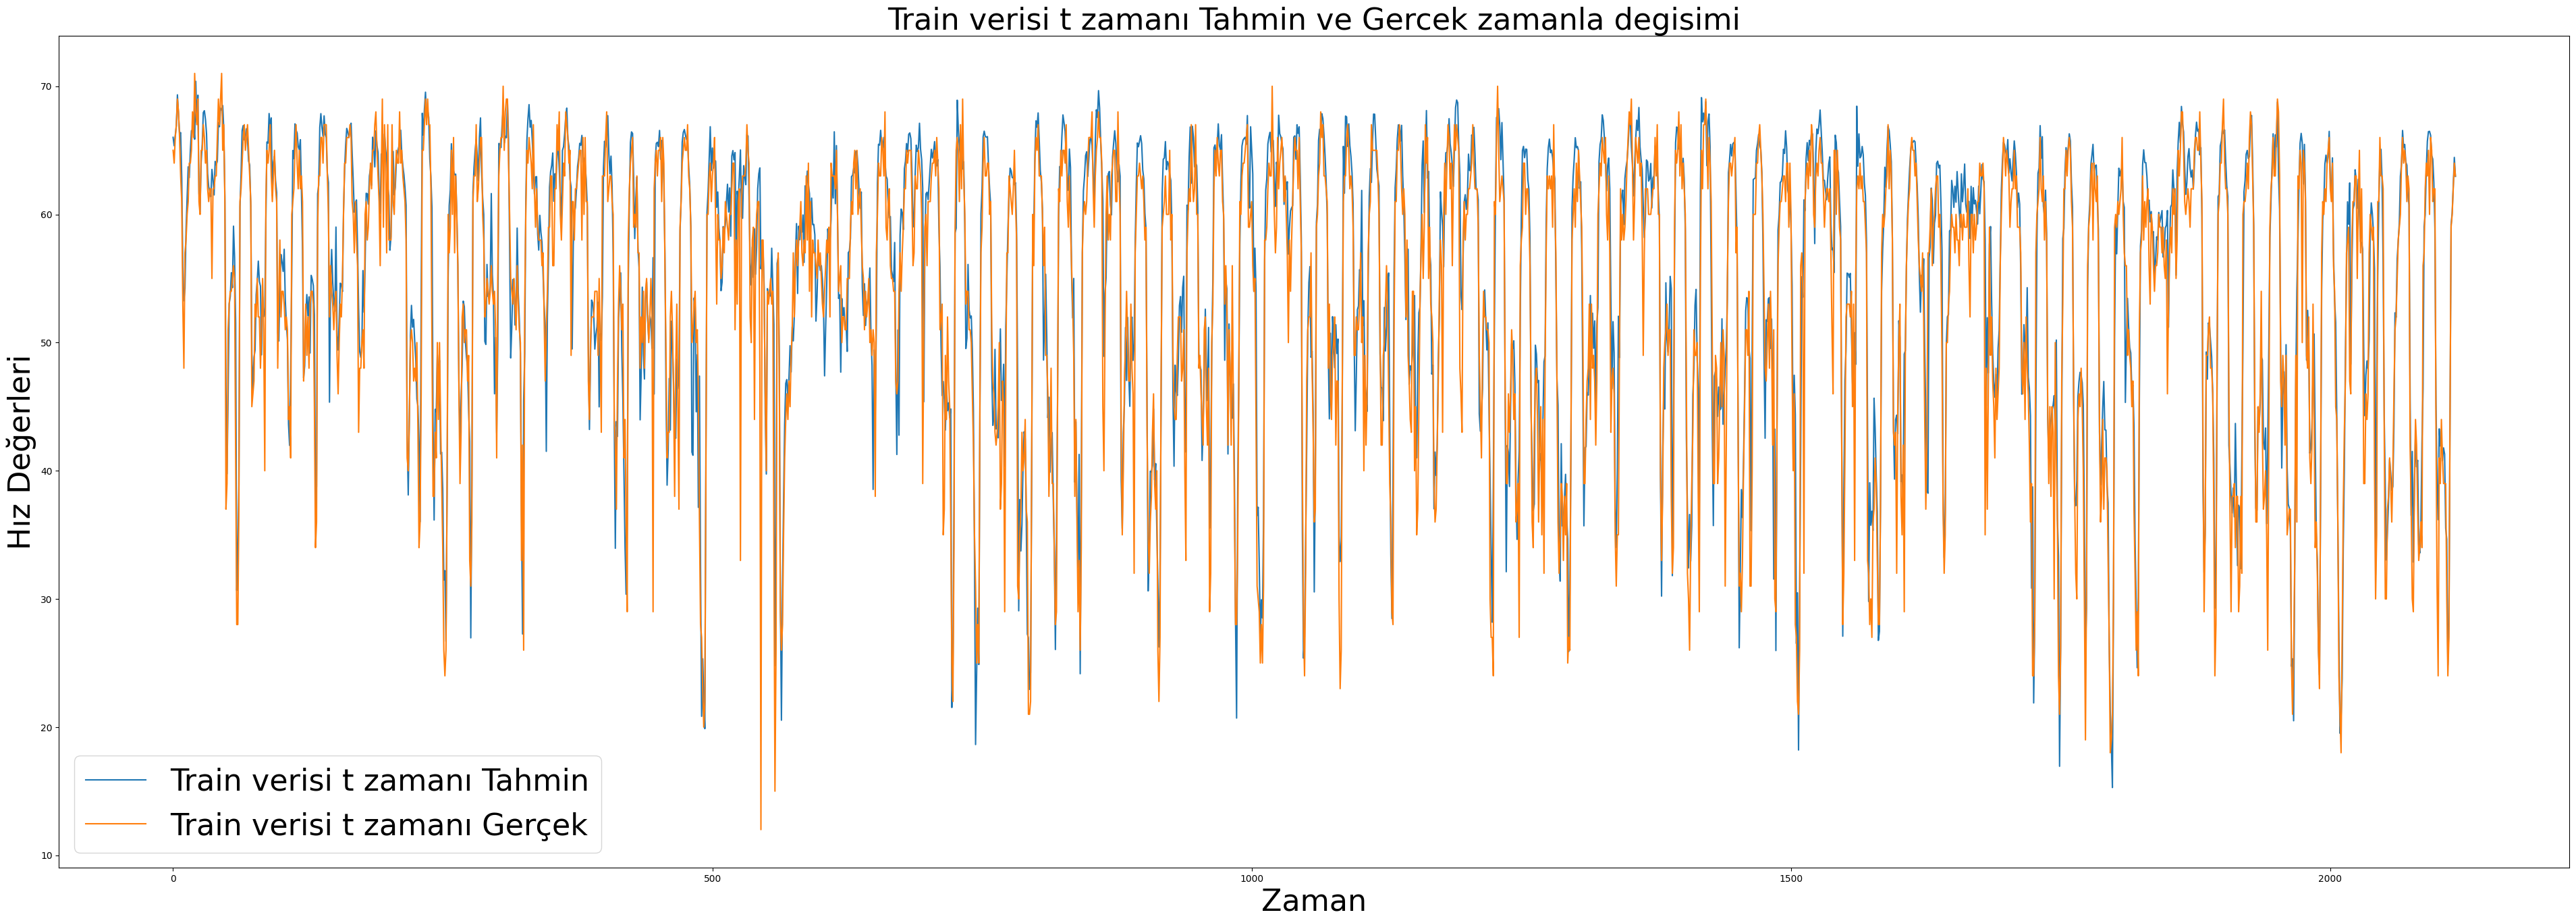

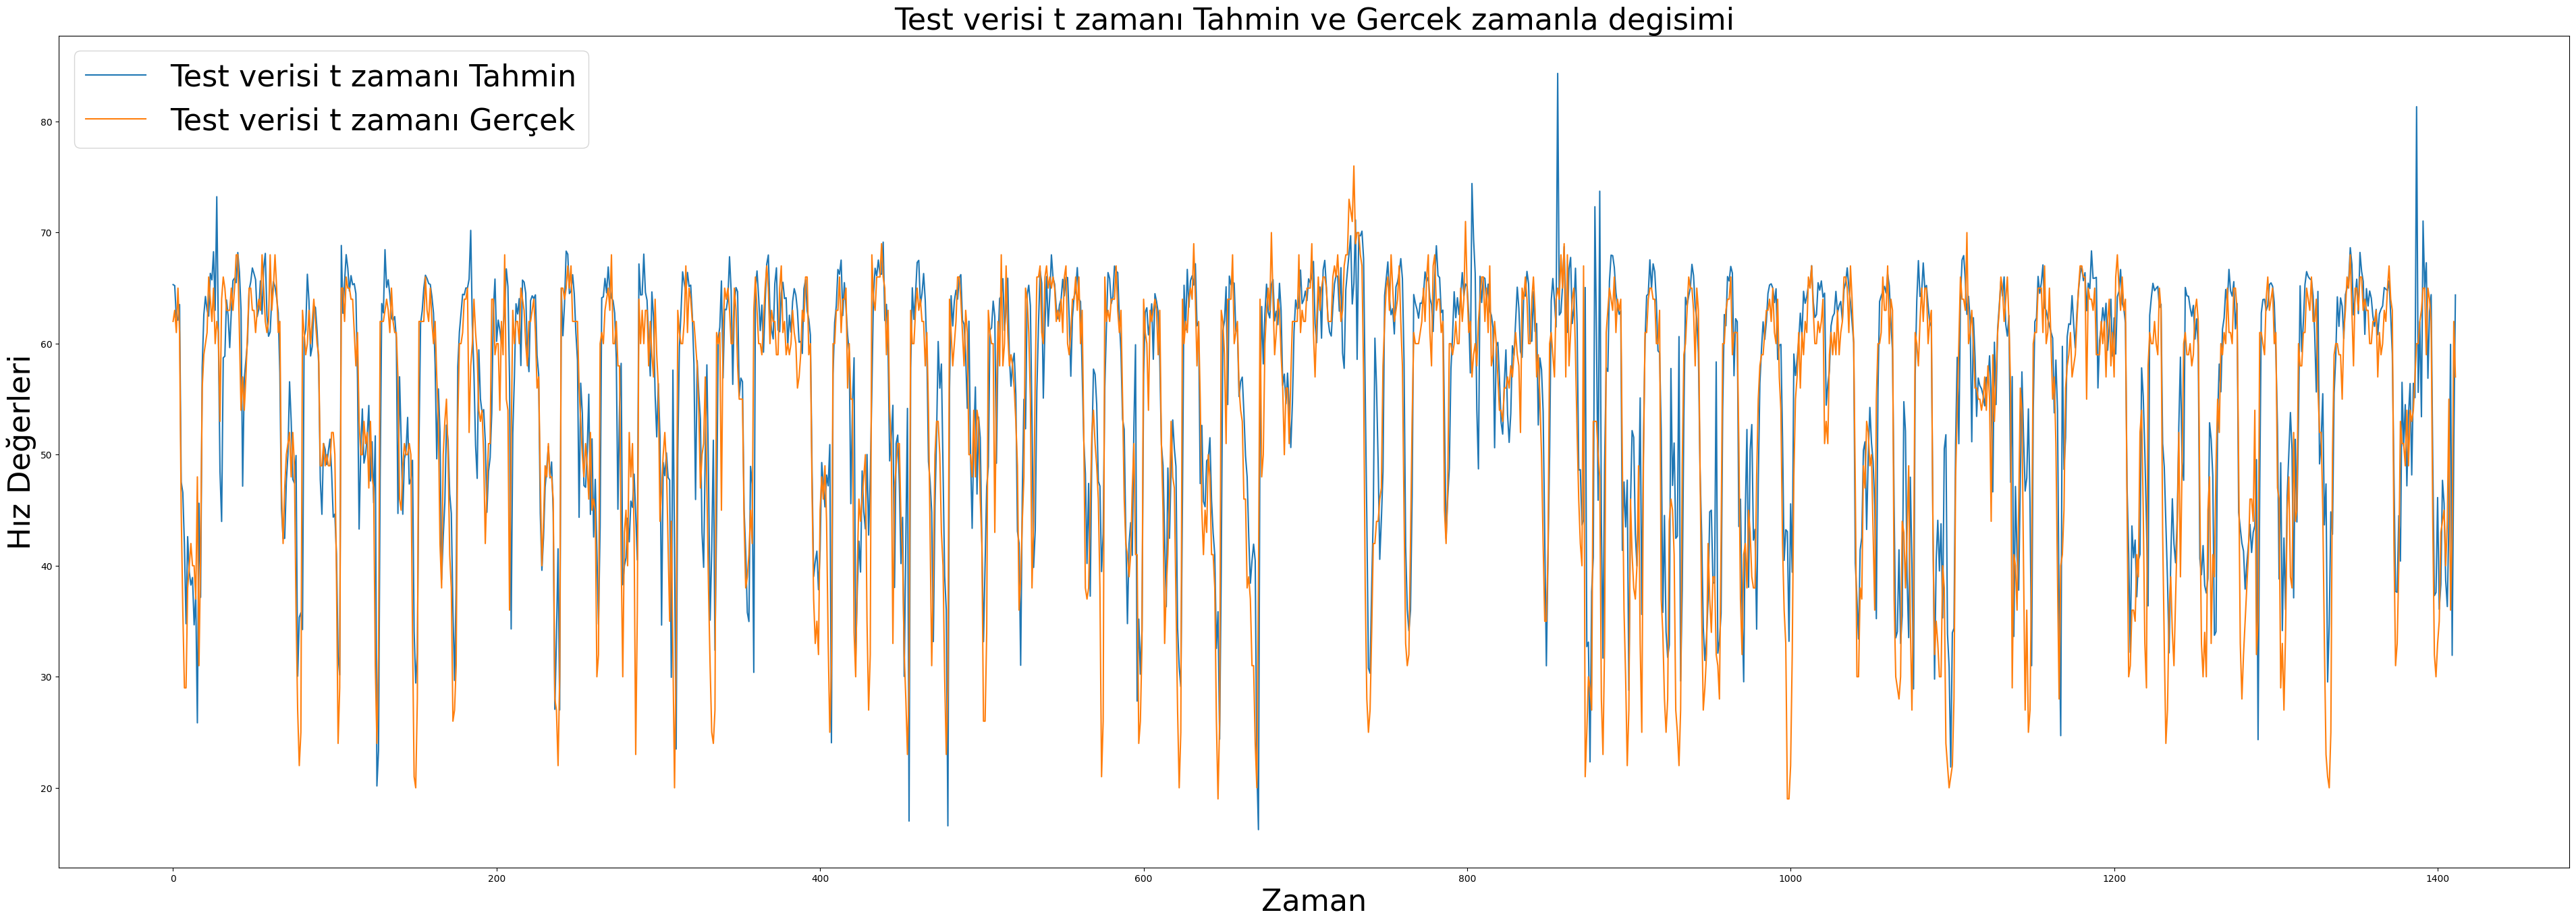

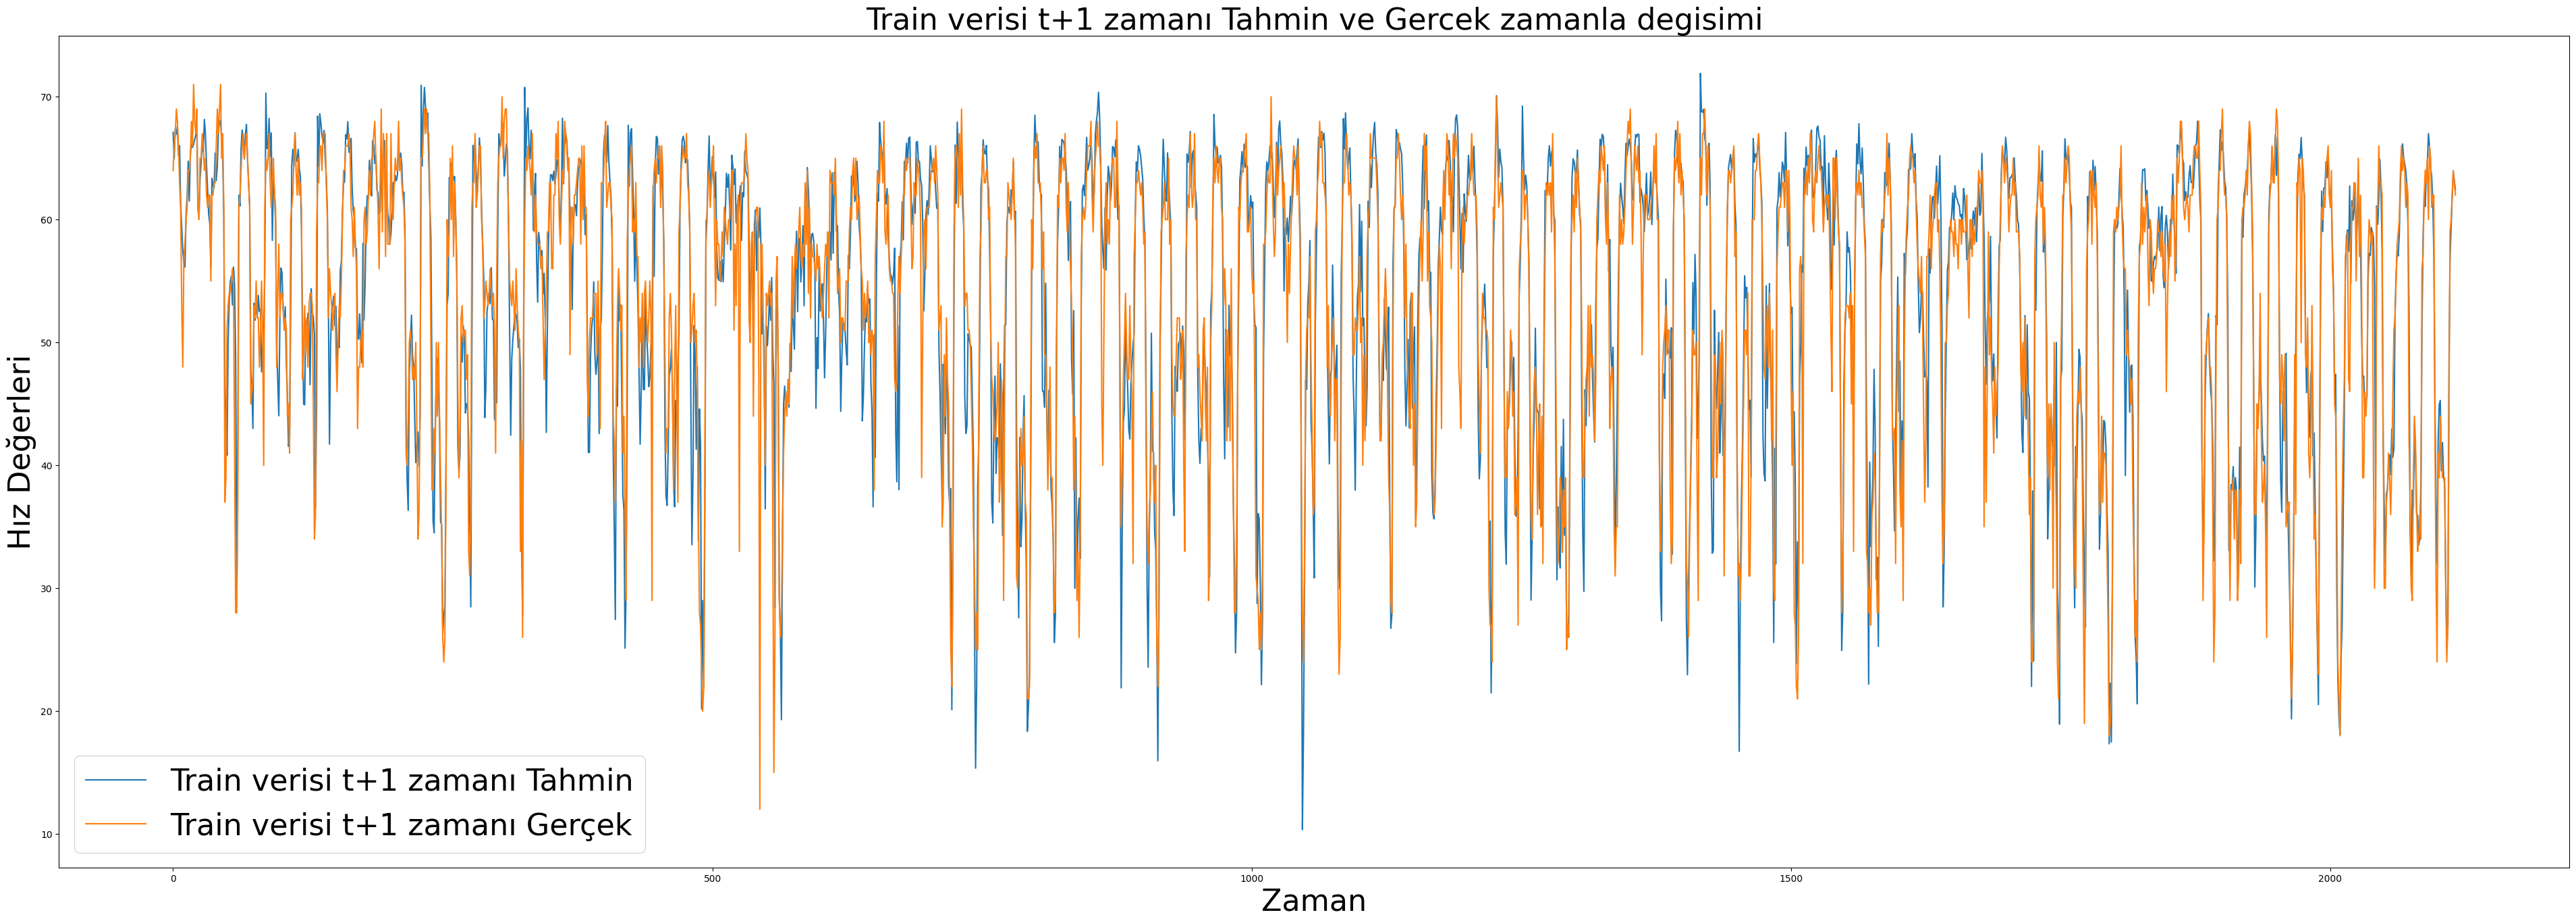

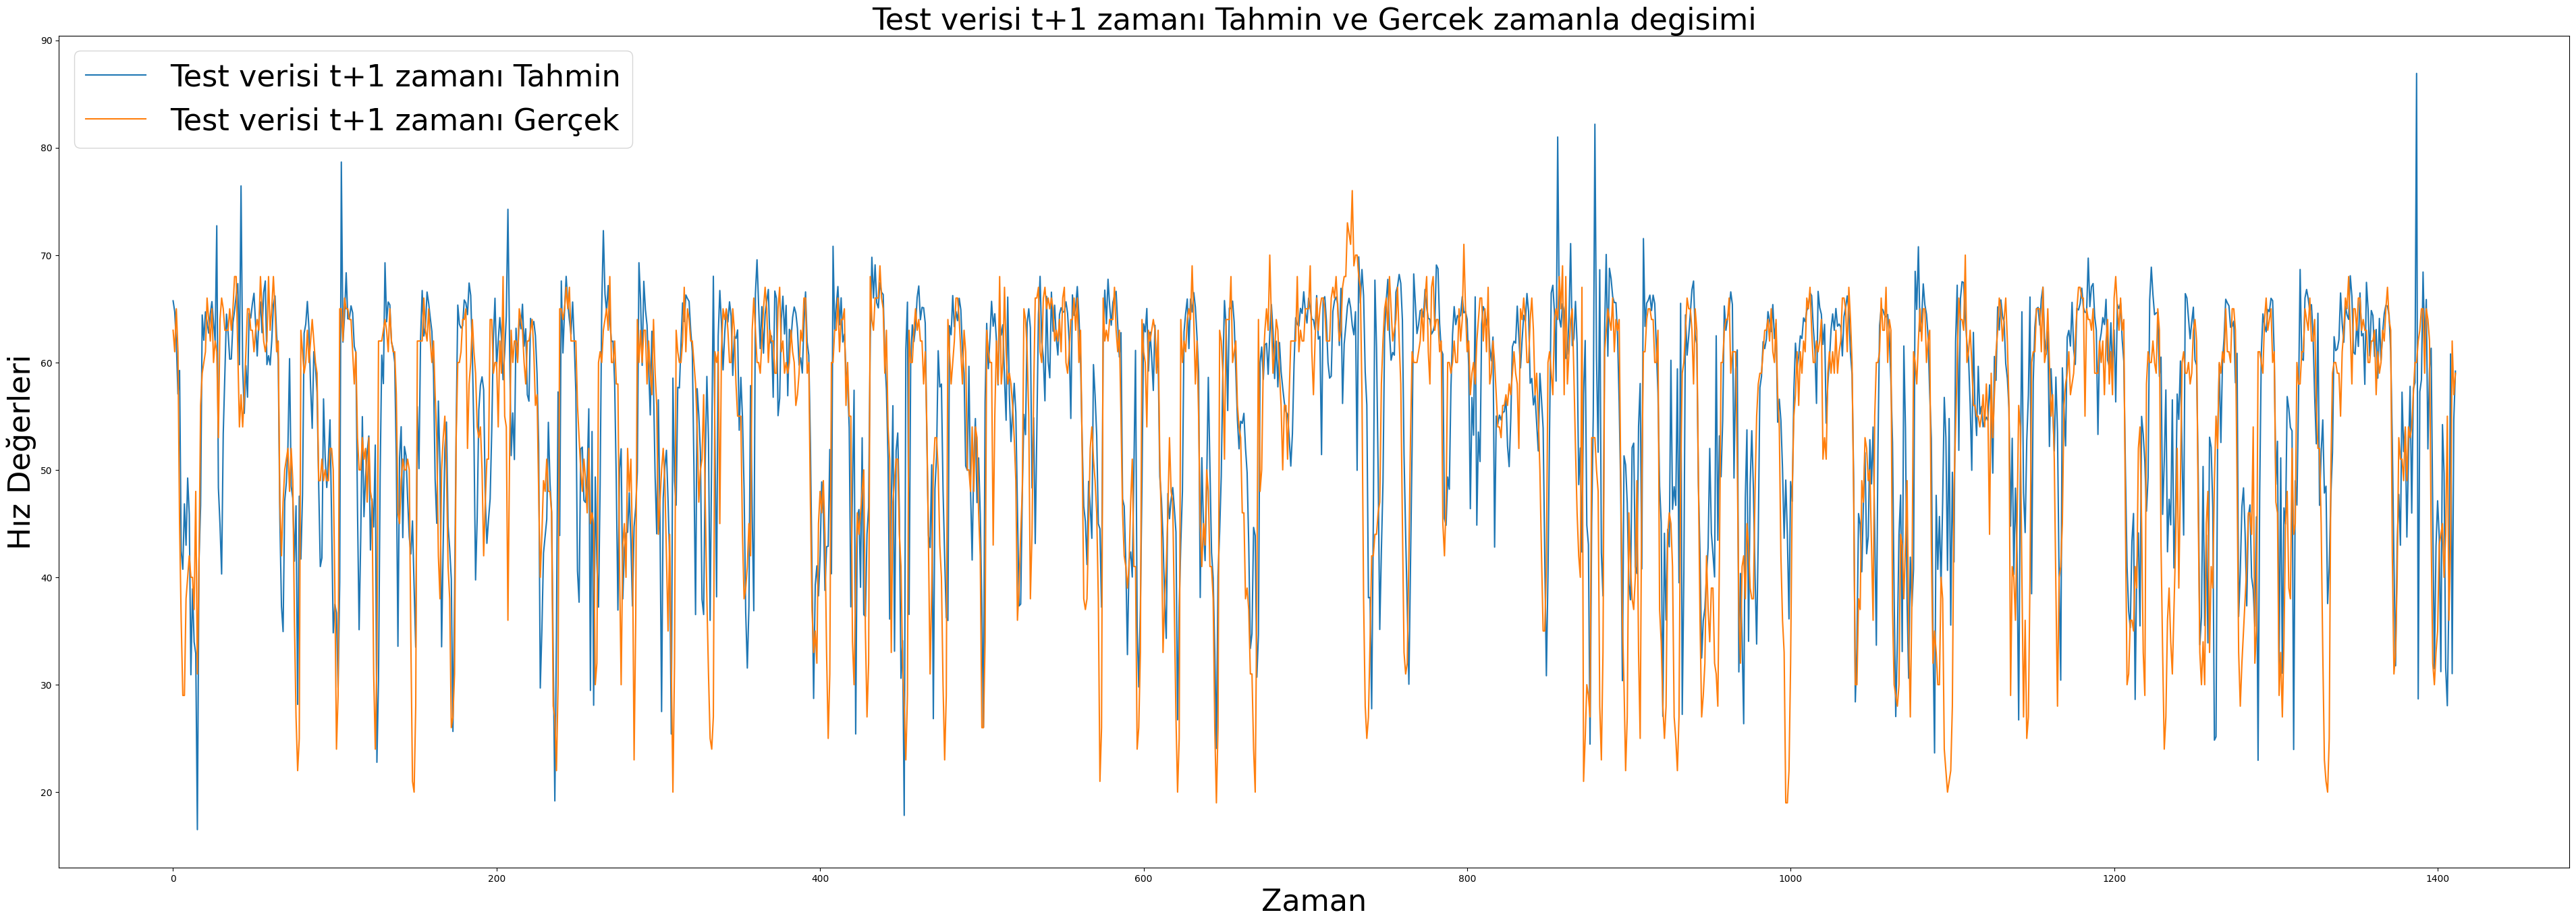

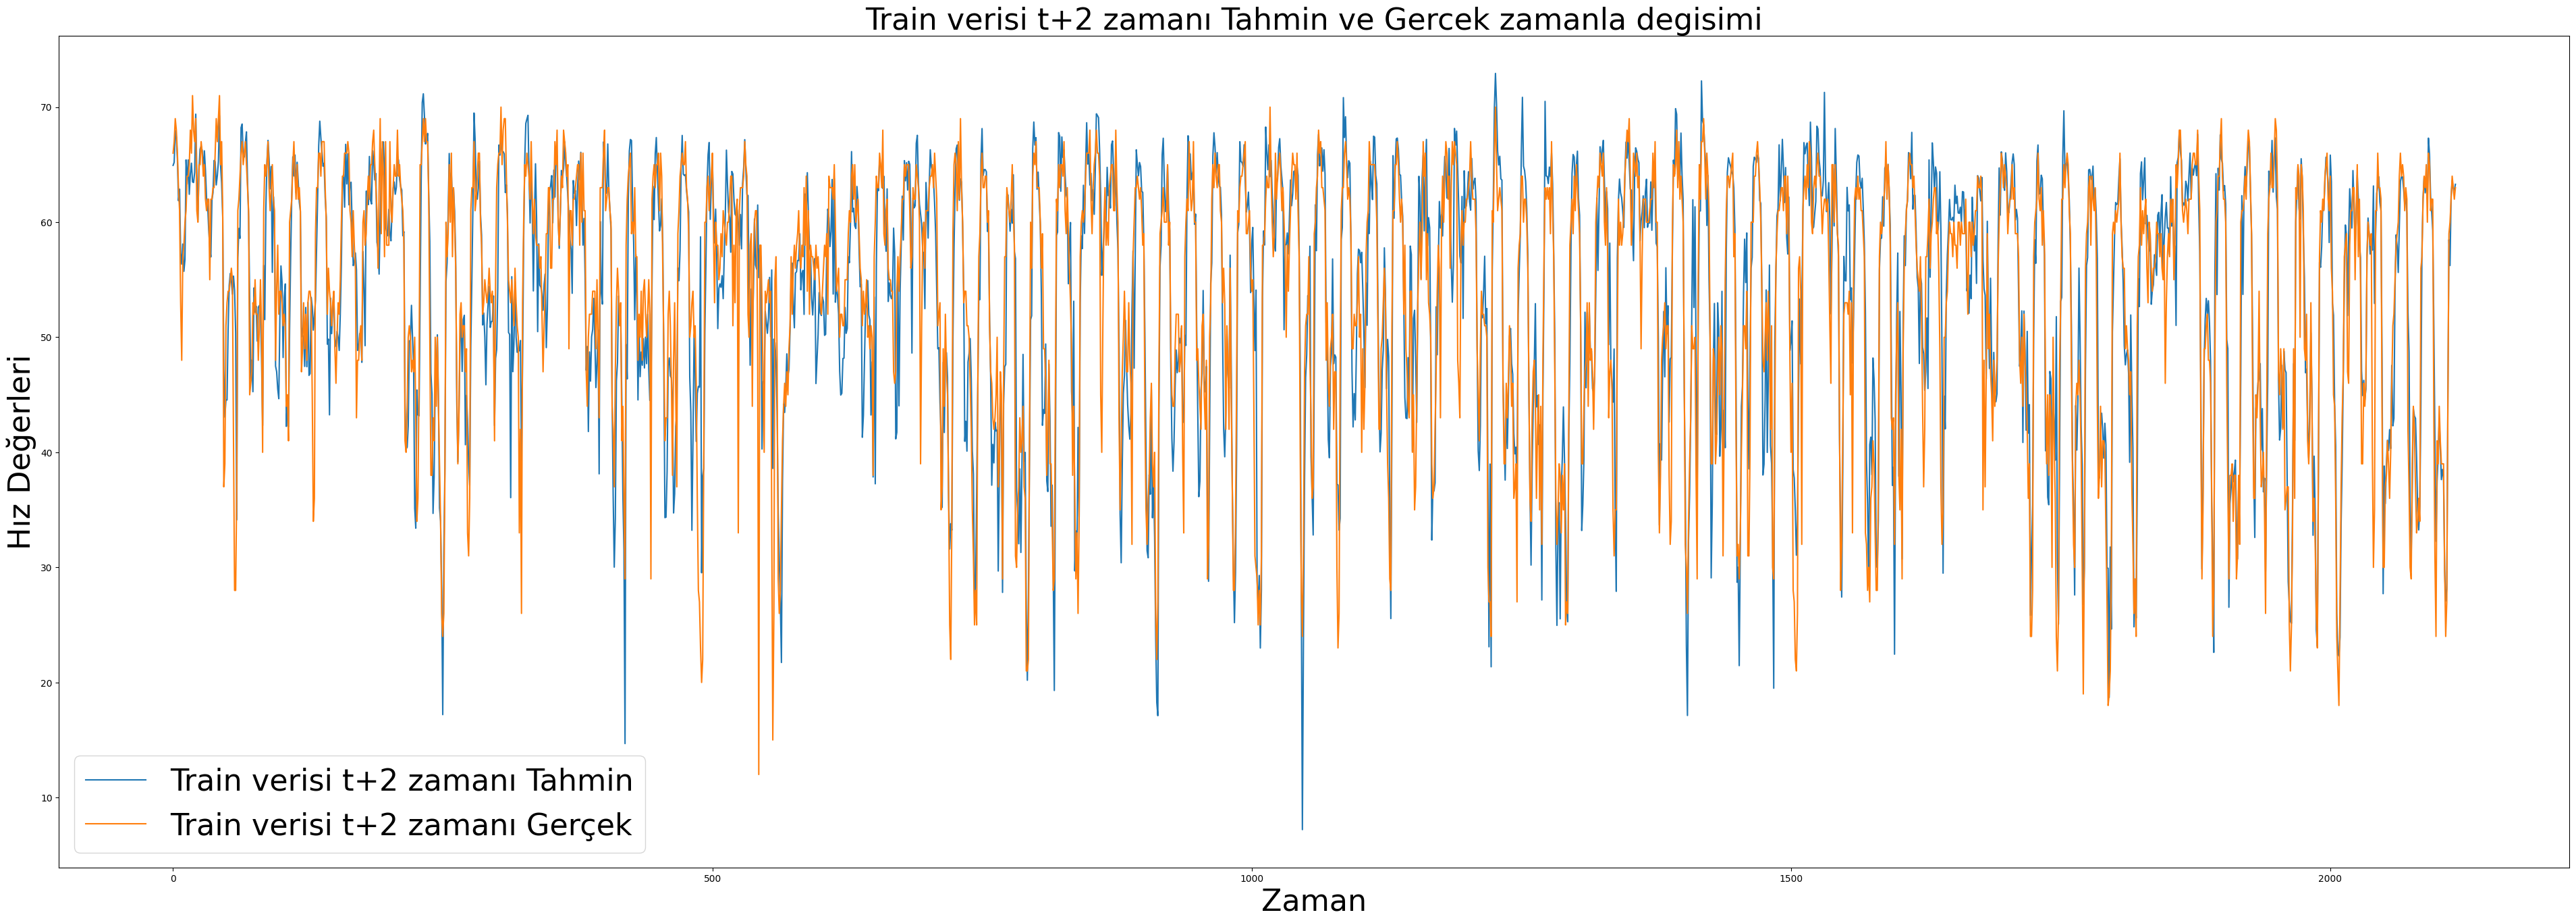

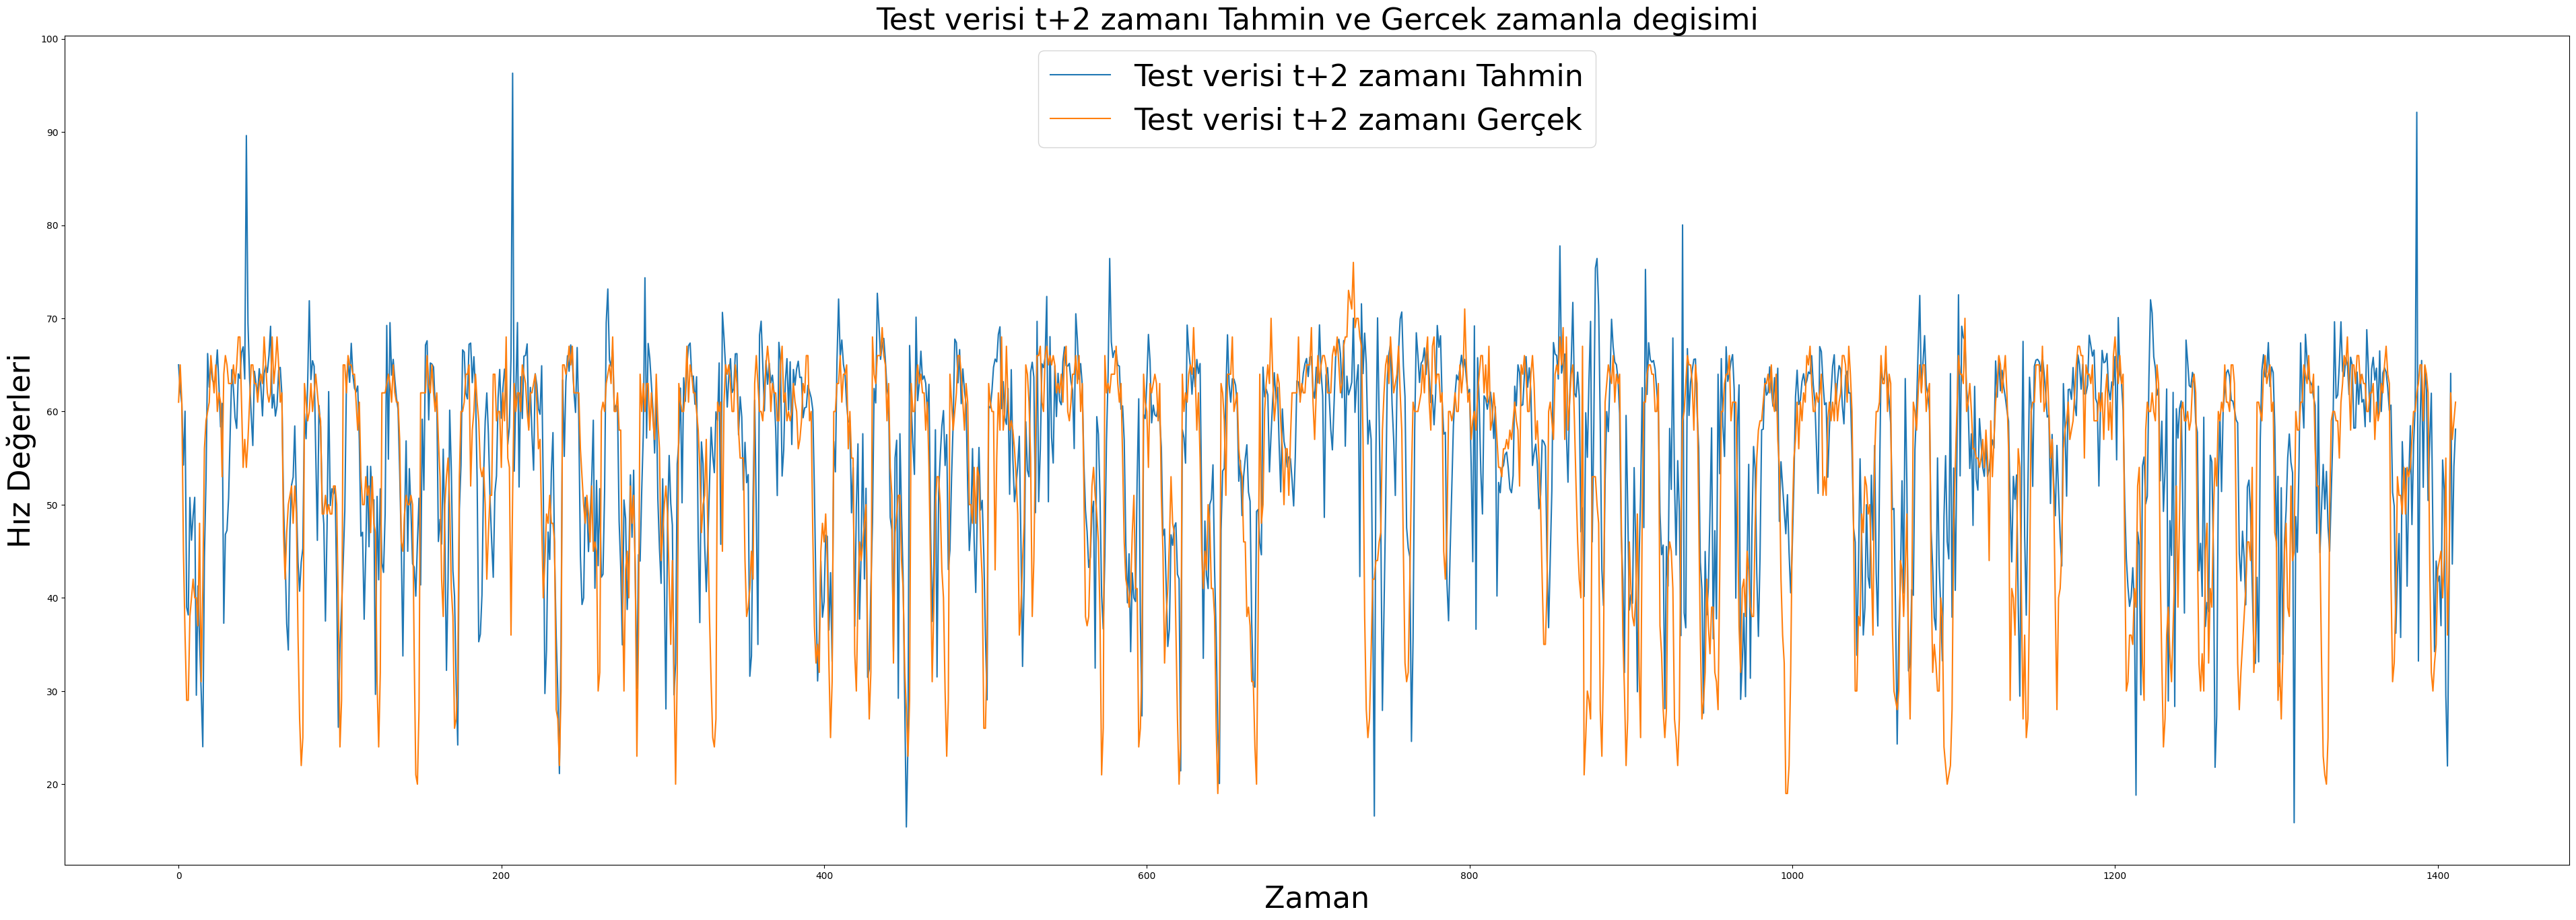

In [18]:
train_y1=train_y[:,0]
pred_train_y1=pred_train_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y1, label = "Train verisi t zamanı Tahmin")
plt.plot(train_y1, label = "Train verisi t zamanı Gerçek")
plt.title('Train verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

test_y1=test_y[:,0]
pred_test_y1=pred_test_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y1, label = "Test verisi t zamanı Tahmin")
plt.plot(test_y1, label = "Test verisi t zamanı Gerçek")
plt.title('Test verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

train_y2=train_y[:,1]
pred_train_y2=pred_train_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y2, label = "Train verisi t+1 zamanı Tahmin")
plt.plot(train_y2, label = "Train verisi t+1 zamanı Gerçek")
plt.title('Train verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')


test_y2=test_y[:,1]
pred_test_y2=pred_test_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y2, label = "Test verisi t+1 zamanı Tahmin")
plt.plot(test_y2, label = "Test verisi t+1 zamanı Gerçek")
plt.title('Test verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

train_y3=train_y[:,2]
pred_train_y3=pred_train_y[:,2]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y3, label = "Train verisi t+2 zamanı Tahmin")
plt.plot(train_y3, label = "Train verisi t+2 zamanı Gerçek")
plt.title('Train verisi t+2 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')


test_y3=test_y[:,2]
pred_test_y3=pred_test_y[:,2]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y3, label = "Test verisi t+2 zamanı Tahmin")
plt.plot(test_y3, label = "Test verisi t+2 zamanı Gerçek")
plt.title('Test verisi t+2 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')